In [ ]:
#TODO
#1. three different tokenization scheme: 0-1, BPE, using commas+BPE

In [3]:
import os
import torch
from datasets import Dataset
from transformers import (
    GPT2Config,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast
)
import numpy as np
from triangle_free import greedy_search_from_startpoint, empty_starting_point, reward_calc
from typing import List, Tuple
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tqdm.auto import tqdm
import random
import logging
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
N = 20

In [38]:
def plot_histogram(rewards: List[float], bins: int = 40):
        """
        Plot and save a histogram of rewards.
        
        Args:
            rewards: List of rewards to plot
            generation: Generation number
            output_dir: Directory to save the plot
        """
        plt.figure(figsize=(10, 6))
        plt.hist(rewards, bins=bins, alpha=0.75, color='blue', edgecolor='black')
        plt.title(f'Reward Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.grid(True)
        # plt.savefig(os.path.join(output_dir, f'reward_histogram_gen_{generation}.png'))
        # plt.close()
        plt.show()


def _generate_sample(_):
    empty = empty_starting_point(N)
    graph = greedy_search_from_startpoint(None, empty, N)
    reward = reward_calc(graph, N)
    return {"text": graph, "reward": reward}

def generate_initial_dataset(num_samples: int = 40000) -> Dataset:
    """
    Generate initial dataset by running greedy search from empty graphs.
    
    Args:
        num_samples: Number of samples to generate
    
    Returns:
        HuggingFace Dataset containing the generated graphs
    """
    dataset_path = f"data/dataset_N{N}_samples{num_samples}"
    if os.path.exists(dataset_path):
        print(f"Loading dataset from {dataset_path}...")
        dataset = Dataset.load_from_disk(dataset_path)
    else:
        print(f"Generating initial dataset with {num_samples} samples...")
        
        # Generate samples using multiprocessing
        with Pool() as pool:
            samples = list(tqdm(pool.imap_unordered(_generate_sample, range(num_samples)), total=num_samples))
        
        dataset = Dataset.from_list(samples)
    return dataset

In [14]:
dataset = generate_initial_dataset(num_samples=40000)

Generating initial dataset with 40000 samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

In [7]:
dataset = Dataset.load_from_disk(f"data/dataset_N{N}_samples40000")

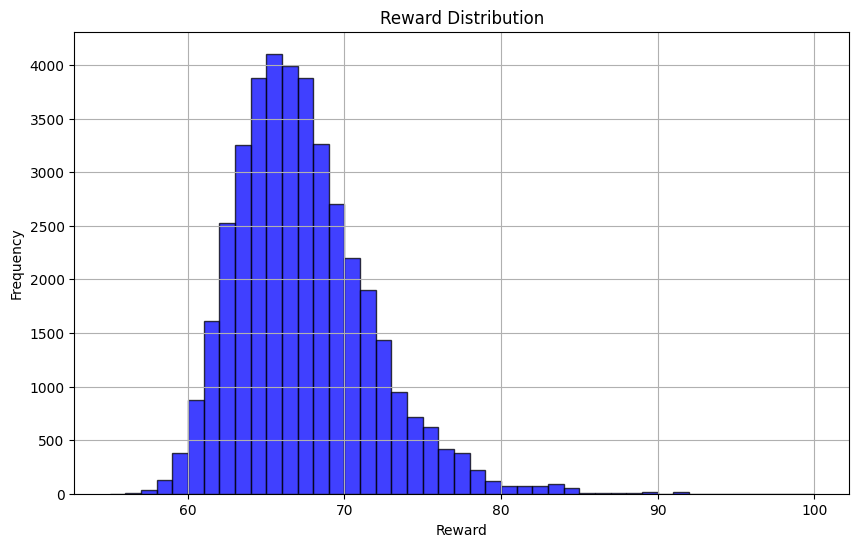

In [5]:
plot_histogram(dataset["reward"], bins=45)

In [26]:
dataset.save_to_disk(f"data/dataset_N{N}_samples40000")

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

In [8]:
# Sort by reward and keep top 25%
dataset = dataset.sort("reward", reverse=True)
best_dataset = dataset.select(range(len(dataset) // 4))

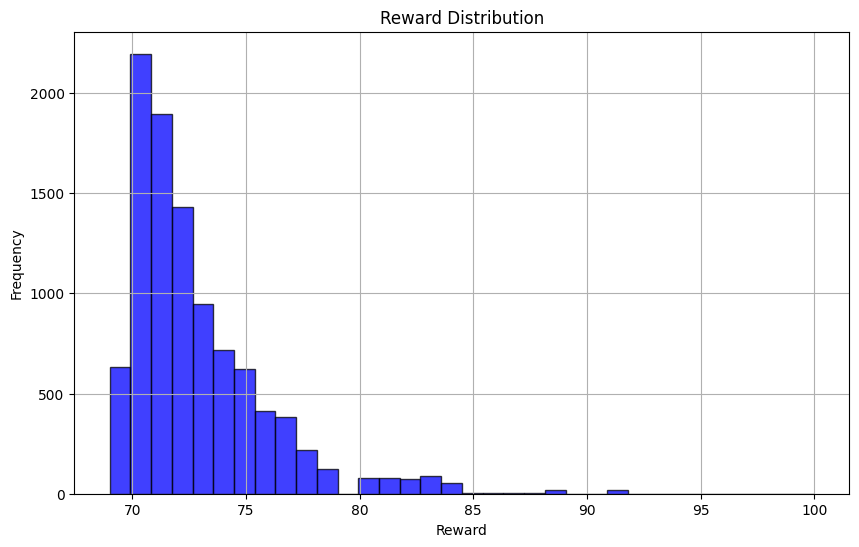

In [11]:
plot_histogram(best_dataset["reward"], bins=34)

#### Training the tokenizer

In [9]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, decoders

# Initialize the Tokenizer with a BPE model
tokenizer = Tokenizer(models.BPE())

# Set up the Trainer with desired parameters
trainer = trainers.BpeTrainer(
    vocab_size=100,
    special_tokens=["<s>", "</s>", "<pad>"],
    show_progress=True
)


tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()



# Train the tokenizer on the dataset
tokenizer.train_from_iterator(dataset['text'], trainer=trainer)


tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    clean_up_tokenization_spaces=True,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>"
)

In [16]:
max_token_length = max([len(tokenizer.encode(text)) for text in dataset['text']])

In [17]:
tokenizer.save_pretrained(f"data/tokenizer_N{N}_samples40000")

('data/tokenizer_N20_samples40000/tokenizer_config.json',
 'data/tokenizer_N20_samples40000/special_tokens_map.json',
 'data/tokenizer_N20_samples40000/tokenizer.json')

In [18]:
def prepare_dataset(dataset: Dataset) -> Dataset:    
    def tokenize_function(examples):
        tokenized_inputs = tokenizer(
            examples["text"],
            padding=True,
            return_tensors="pt"
        )
        return tokenized_inputs
    
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True
    )
    
    return tokenized_dataset

In [19]:
tokenized_dataset = prepare_dataset(best_dataset)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [22]:
config = GPT2Config(
            vocab_size=len(tokenizer),
            n_positions=max_token_length,  # Maximum length of our graph strings
            n_layer=2,
            n_head=4,
            n_embd=16,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            torch_dtype=torch.bfloat16,
            torch_compile=True
        )

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")

In [24]:
model = AutoModelForCausalLM.from_config(config)

# 5. Prepare a data collator for causal language modeling.
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [25]:
output_dir = f"data/"
training_args = TrainingArguments(
    output_dir=output_dir,
    max_steps=15000,
    per_device_train_batch_size=32,
    learning_rate=5e-4,
    weight_decay=0.01,
    eval_strategy="no",
    save_strategy="no",
    logging_dir=os.path.join(output_dir, "logs"),
    logging_steps=100,
    report_to="none",
    bf16=True,  # Enable bfloat16
    torch_compile=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator
)

max_steps is given, it will override any value given in num_train_epochs


In [26]:
trainer.train()

Step,Training Loss
100,4.387600
200,4.179700
300,4.150400
400,4.125200
500,4.105500
600,4.082600
700,4.058800
800,4.037200
900,4.028600
1000,4.015500


TrainOutput(global_step=15000, training_loss=3.922339247639974, metrics={'train_runtime': 497.0904, 'train_samples_per_second': 965.619, 'train_steps_per_second': 30.176, 'total_flos': 757558124544.0, 'train_loss': 3.922339247639974, 'epoch': 47.92332268370607})

In [27]:
# Save dataset
print("Saving dataset...")
#dataset.save_to_disk(f"data/dataset_N{N}_samples{len(dataset)}_best")

# Save tokenizer
print("Saving tokenizer...")
tokenizer.save_pretrained(f"data/tokenizer_N{N}_samples{len(dataset)}")

# Save model
print("Saving model...")
model.save_pretrained(f"data/model_N{N}_samples{len(best_dataset)}_generation1")

print("Done saving all artifacts.")

Saving dataset...
Saving tokenizer...
Saving model...
Done saving all artifacts.


In [ ]:
num_samples = int(1e2)
batch_size = 32
generated_samples = []

for i in tqdm(range(0, num_samples, batch_size)):
    batch_input_ids = torch.tensor([[tokenizer.bos_token_id]] * min(batch_size, num_samples - i)).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            batch_input_ids,
            max_length=N * (N - 1) // 2,
            num_return_sequences=min(batch_size, num_samples - i),
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            temperature=1.0,
        )
        outputs = outputs.sequences if hasattr(outputs, 'sequences') else outputs
        generated_samples.extend([tokenizer.decode(output.tolist(), skip_special_tokens=True) for output in outputs])
    
    # Clear cache to free up memory
    torch.cuda.empty_cache()

In [29]:
batch_input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)

In [30]:
batch_input_ids

tensor([[0]], device='cuda:0')

In [31]:
test_outputs = model.generate(
            batch_input_ids,
            max_length=max_token_length,
            num_return_sequences=int(1e2),
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            temperature=1.0,
        )

In [32]:
decoded_test_outputs = [''.join(s.split()) for s in tokenizer.batch_decode(test_outputs, skip_special_tokens=True)]

In [37]:
truncated_test_outputs = [s[:190] for s in decoded_test_outputs if len(s) >= 190]

In [ ]:
ones_count = [s.count('1') for s in truncated_test_outputs]
print(f"Average number of 1's: {sum(ones_count)/len(ones_count):.2f}")
print(f"Min number of 1's: {min(ones_count)}")
print(f"Max number of 1's: {max(ones_count)}")

In [39]:
new_reward = [reward_calc(graph, N) for graph in truncated_test_outputs]

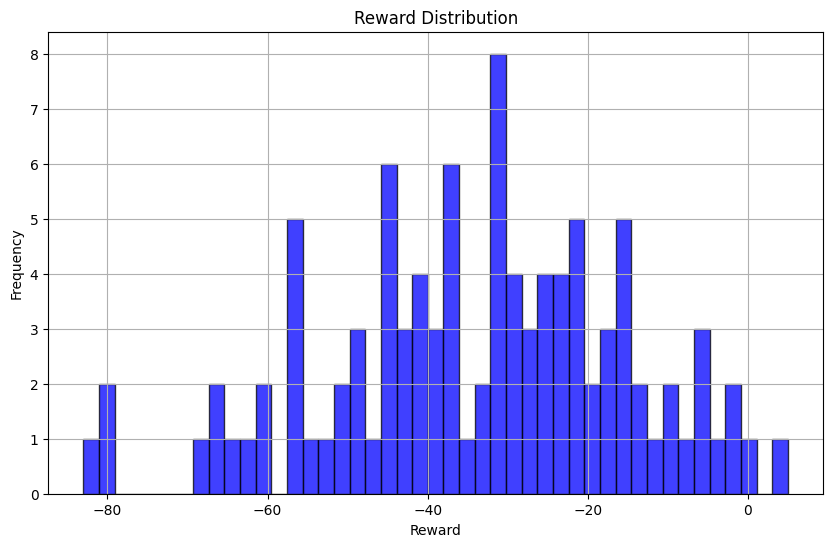

In [41]:
plot_histogram(new_reward, bins=45)

In [42]:
new_reward_simple = [graph.count('1') for graph in truncated_test_outputs]

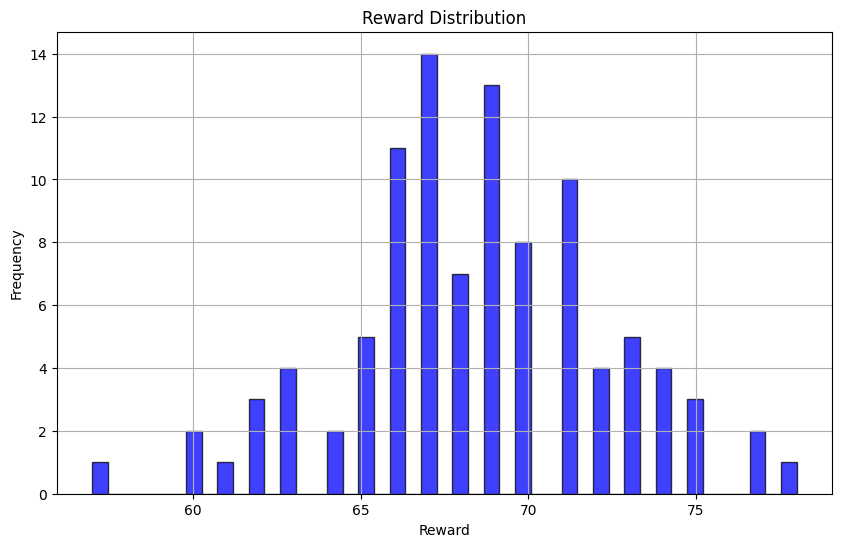

In [43]:
plot_histogram(new_reward_simple, bins=45)

In [100]:
''.join(tokenizer.decode(tokenizer.encode("1010110101010010100111100101"), skip_special_tokens=True, clean_up_tokenization_spaces=True).split()) == "1010110101010010100111100101"

True

In [ ]:
def clean_graph_string(graph_string: str) -> str:
    """Remove all whitespaces from a graph string."""
    return ''.join(graph_string.split())

# Clean the generated samples
generated_samples = [clean_graph_string(sample) for sample in generated_samples]

In [ ]:
samples = model.generate_samples(samples_per_generation)

# Run greedy search on generated samples
new_samples = []
for sample in tqdm(samples, desc="Running greedy search"):
    try:
        # Skip invalid samples
        if len(sample) != N * (N - 1) // 2 or not all(c in '01' for c in sample):
            continue
        result = greedy_search_from_startpoint(None, sample, N)
        reward = reward_calc(result, N)
        new_samples.append({"text": result, "reward": reward})
    except Exception as e:
        logger.warning(f"Error processing sample: {e}")

In [ ]:
# X_init = torch.zeros(num, 1, dtype=torch.long).to(args.device)
# top_k = args.top_k if args.top_k != -1 else None
# steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
# X_samp = generate(model, X_init, steps, temperature = args.temperature, top_k=top_k, do_sample=True).to('cpu')
'''
def get_parser():
    parser = argparse.ArgumentParser('Generate training sample of low braids via reservoir sampling')
    # JULIA params
    
    parser.add_argument('--num_initial_empty_objects', type=int, default=50000, help='number of initial rollouts, before the first learning loop')
    parser.add_argument('--final_database_size', type=int, default=5000, help='training set size')
    parser.add_argument('--target_db_size', type=int, default=50000, help='size of cache during local search loop, should be larger than training set size')
    parser.add_argument('--sample-only', type=int, default=50000, help="sample the specified number from the model in each loop")
    parser.add_argument('--nb_threads', type=int, default=8, help='Number of cpu threads')
    parser.add_argument('--nb_local_searches', type=int, default=1200, help='This only matters when using multithreading, then it should be a multiple of the number of threads used')
    

    # Makemore params
    parser.add_argument('--num-workers', '-n', type=int, default=8, help="number of data workers for both train/test")
    parser.add_argument('--max-steps', type=int, default=2000, help="max number of optimization steps to run for, or -1 for infinite.")
    parser.add_argument('--max_epochs', type=int, default= 300, help='number of epochs')
    parser.add_argument('--seed', type=int, default=-1, help="seed")
    # sampling
    parser.add_argument('--top-k', type=int, default=-1, help="top-k for sampling, -1 means no top-k")
    # model
    parser.add_argument('--type', type=str, default='transformer', help="model class type to use, bigram|mlp|rnn|gru|bow|transformer")
    parser.add_argument('--n-layer', type=int, default=2, help="number of layers")
    parser.add_argument('--n-head', type=int, default=4, help="number of heads (in a transformer)")
    parser.add_argument('--n-embd', type=int, default=16, help="number of feature channels in the model")
    parser.add_argument('--n-embd2', type=int, default=32, help="number of feature channels elsewhere in the model")
    # optimization
    parser.add_argument('--batch-size', '-b', type=int, default=16, help="batch size during optimization")
    parser.add_argument('--learning-rate', '-l', type=float, default=5e-4, help="learning rate")
    parser.add_argument('--weight-decay', '-w', type=float, default=0.01, help="weight decay")
    # evaluation against known "good sequences"
    parser.add_argument('--max-output-length', type=int, default=160, help="maximum output length")
    parser.add_argument('--gen_batch_size', type=int, default=1000, help="generation batch size")
    parser.add_argument('--n_tokens', type=int, default=100, help="nr tokens in tokenizer")
    parser.add_argument('--temperature', type=float, default=1.0, help="temperature")
'''